In [36]:
import xarray as xr

netcdf to zarr

In [37]:
import numpy as np
import xarray as xr

def main():
    """
    Converts Level 1B crs data from s3 to zarr file and then stores it in the provided folder
    Args:
        folder (string): name to hold the raw files.
        file (string): the s3 url to the raw file.
    """

    # open dataset.
    with xr.open_dataset("./tmp/CPEXAW-DROPSONDE_D20210820_203208_PQC.nc", decode_cf=False) as ds:
    # with xr.open_dataset("./tmp/CPEXAW-DROPSONDE_D20210806_193025_PQC.nc", decode_cf=False) as ds:
        rh = ds['rh'].values # relative humidity
        dp = ds['dp'].values # dew point
        tdry = ds['tdry'].values # temp dry???
        lat = ds['lat'].values
        lon = ds['lon'].values
        alt = ds['alt'].values
        time = ds['time'].values
        pressure = ds['pres'].values
        u_wind = ds['u_wind'].values
        v_wind = ds['v_wind'].values

    # data formation
    
    # sort data by time
    sort_idx = np.argsort(time)

    lon = lon[sort_idx]
    lat = lat[sort_idx]
    alt = alt[sort_idx]
    time = time[sort_idx]
    rh = rh[sort_idx]
    dp = dp[sort_idx]
    tdry = tdry[sort_idx]
    pressure = pressure[sort_idx]
    u_wind = u_wind[sort_idx]
    v_wind = v_wind[sort_idx]

    # remove nan and infinite using mask ???
    mask = np.logical_and(alt != -999.0, lon != -999.0, lat != -999.0)
    # mask = np.logical_and(np.isfinite(ref), alt > 0, alt != -999.0, lon != -999.0, lat != -999.0)
    lon = lon[mask]
    lat = lat[mask]
    alt = alt[mask]
    time = time[mask]
    rh = rh[mask]
    dp = dp[mask]
    tdry = tdry[mask]
    pressure = pressure[mask]
    u_wind = u_wind[mask]
    v_wind = v_wind[mask]

    # remove nan and infinite using mask ???
    mask = np.logical_and(rh > -100, rh > -100)
    # mask = np.logical_and(np.isfinite(ref), alt > 0, alt != -999.0, lon != -999.0, lat != -999.0)
    lon = lon[mask]
    lat = lat[mask]
    alt = alt[mask]
    time = time[mask]
    rh = rh[mask]
    dp = dp[mask]
    tdry = tdry[mask]
    pressure = pressure[mask]
    u_wind = u_wind[mask]
    v_wind = v_wind[mask]
    

    return (lon, lat, alt, time, rh, dp, tdry, pressure, u_wind, v_wind)

# USING LIBRARIES TO PLOT SKEW-T DIAGRAM

In [38]:
(lon, lat, alt, time, rh, dp, tdry, pressure, u_wind, v_wind) = main()

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units

In [40]:
# Change default to be better for skew-T
plt.rcParams['figure.figsize'] = (9, 9)

In [41]:
df = pd.DataFrame(dict(zip(('height','pressure','temperature','dewpoint','u_wind','v_wind'),(alt,pressure,tdry,dp,u_wind,v_wind))))

# Drop any rows with all NaN values for T, Td, winds
df = df.dropna(subset=('height','pressure','temperature','dewpoint','u_wind','v_wind', 
                       ), how='all').reset_index(drop=True)

In [42]:
P = df['pressure'].values * units.hPa
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC

(1000.0, 100.0)

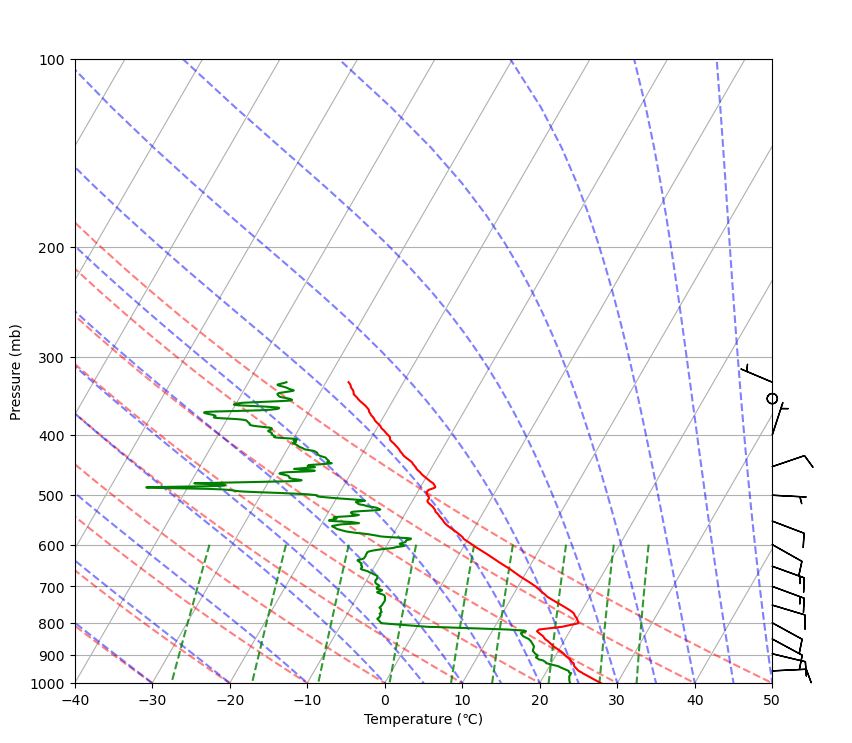

In [43]:
skew = SkewT()

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(P, T, 'r')
skew.plot(P, Td, 'g')

# # Set some better labels than the default
skew.ax.set_xlabel('Temperature (\N{DEGREE CELSIUS})')
skew.ax.set_ylabel('Pressure (mb)')

## for barbs

# Set spacing interval--Every 50 mb from 1000 to 100 mb
my_interval = np.arange(100, 1000, 50) * units('mbar')

# Get indexes of values closest to defined interval
ix = mpcalc.resample_nn_1d(P, my_interval)
skew.plot_barbs(P[ix], u_wind[ix], v_wind[ix])

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()
skew.ax.set_ylim(1000, 100)